# Metody analýzy sítí

Tento projekt se zaměřuje na výpočet a vizualizaci různých metrik sítě, konkrétně na analýzu sítě Facebook. Data, která jsou k dispozici na [Snap repository](https://snap.stanford.edu/data/facebook-large-page-page-network.html), obsahují informace o uzlech a hranách, kde uzly představují oficiální Facebook stránky a hrany představují vzájemné "lajky" mezi stránkami. Uzlové atributy jsou získány z popisů stránek, které jejich vlastníci vytvořili k shrnutí účelu stránky. Tento webgraf byl shromážděn prostřednictvím Facebook Graph API v listopadu 2017 a je omezen na stránky ze čtyř kategorií definovaných Facebookem: **politici**, **vládní organizace**, **televizní pořady** a **firmy**. Úkolem spojeným s tímto datasetem je klasifikace uzlů do těchto čtyř kategorií. Data byla zpracována v programu Gephi, kde byly vypočteny různé metriky sítě a výsledky exportovány do CSV souboru, který je nyní zpracován v tomto notebooku.

# Načtení knihoven

In [36]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
import community as community_louvain

# Načtení dat

In [37]:
gephi_table = '../results/project/gephi_result.csv'
edge_file = '../datasets/facebook/musae_facebook_edges.csv'

In [38]:
print(f"Poslední dvě hrany v souboru:")
with open(edge_file, 'r') as f:
    lines = f.readlines()
    for line in lines[-2:]:
        print(line)

    print(f"Celkový počet hran v souboru: {len(lines)}")


Poslední dvě hrany v souboru:
5563,5563

22425,22425

Celkový počet hran v souboru: 171003


Nevím proč, ale `Gephi` i `networkx` mají problémy se souborem s hrany. Vytvoří dva uzly s hodnotou `NaN` a zkomplikuje to naše poznatky a měření. Proto je zahodíme. Sedí to i s informacemi od autora datasetu.

# Explorace dat

In [39]:
gephi_df = pd.read_csv(gephi_table)
gephi_df.head()

,Id,Label,page_name,page_type,Degree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,Authority,Hub,componentnumber,modularity_class,stat_inf_class,clustering,triangles,lp_community
0,0,0,The Voice of China 中国好声音,tvshow,1,1,11,0.182482,0.188012,0.000000,0.000000,0.000000,0,39,0,0.000000,0,0
1,1,1,U.S. Consulate General Mumbai,government,34,34,9,0.257752,0.277288,38599.953671,0.007947,0.007947,0,41,0,0.481283,270,1
2,2,2,ESET,company,12,12,11,0.189540,0.196693,737.906647,0.000003,0.000003,0,17,0,0.651515,43,5
3,3,3,Consulate General of Switzerland in Montreal,government,10,10,10,0.219007,0.229082,13135.482364,0.000016,0.000016,0,8,0,0.511111,23,6
4,4,4,Mark Bailey MP - Labor for Miller,politician,51,51,10,0.230387,0.244486,31660.834738,0.000114,0.000114,0,32,0,0.420392,536,8


## Zahození nepotřebných sloupců

In [40]:
gephi_df = gephi_df.drop(columns=['Label'])

## Jména sloupců

In [41]:
gephi_df.columns

Index(['Id', 'page_name', 'page_type', 'Degree', 'Weighted Degree',
       'Eccentricity', 'closnesscentrality', 'harmonicclosnesscentrality',
       'betweenesscentrality', 'Authority', 'Hub', 'componentnumber',
       'modularity_class', 'stat_inf_class', 'clustering', 'triangles',
       'lp_community'],
      dtype='object')

## Vytvoření instancí třídy `Graph` z knihovny `networkx`

Vytvoření grafu z hrany a uzlů pro lepší počítání metrik sítě. Zahodíme poslední dvě hrany, které obsahují `NaN` hodnoty.

In [42]:
edge_file = '../datasets/facebook/musae_facebook_edges.csv'
edges = pd.read_csv(edge_file)
edges = edges.dropna()

In [43]:
G = nx.Graph()
G.add_edges_from(edges.values)

## Počet uzlů a hran

In [44]:
total_node_count = G.number_of_nodes()
total_edge_count = G.number_of_edges()
print(f'Počet uzlů: {total_node_count}\nPočet hran: {total_edge_count}')

Počet uzlů: 22470
Počet hran: 171002


## Hustota sítě

In [45]:
density = nx.density(G)
density

0.000677398715568023

## Průměrný stupeň uzlu

In [46]:
average_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
average_degree

15.220471740097908

## Maximální stupeň uzlu

In [47]:
max_degree = max(dict(G.degree()).values())
max_degree

709

## Počet komponent

In [48]:
num_components = nx.number_connected_components(G)
num_components

1

## Distribuce stupňů

In [49]:
degree_values = dict(G.degree()).values()
degree_values = pd.Series(degree_values)
degree_values = degree_values.value_counts().sort_index()
print(f"Celokový počet distribuce stupňů: {len(degree_values)}")

Celokový počet distribuce stupňů: 233


To si asi necháme pro vizualizaci.

Na levém grafu, který zobrazuje distribuci stupňů v lineárním měřítku, je zřejmé, že většina uzlů v síti má nízký stupeň, tedy mají malý počet spojení, ale existuje malé množství uzlů s extrémně vysokým stupněm, tedy velmi mnoho spojení. Zde se bude pravděpodobně jednat o uzly, které jsou velmi populární a mají mnoho spojení s ostatními uzly a může se jednot o "hub" uzly.

## Počet unikátních hodnot kategorií

### Počet unikátních hodnot kategorií

In [50]:
gephi_df['page_type'].value_counts()

page_type
government    6880
company       6495
politician    5768
tvshow        3327
Name: count, dtype: int64

### Počet unikátních hodnot kategorií v procentech

In [51]:
gephi_df['page_type'].value_counts(normalize=True) * 100

page_type
government    30.618603
company       28.905207
politician    25.669782
tvshow        14.806409
Name: proportion, dtype: float64

In [52]:
# Group by modularity_class, then use nlargest to get the biggest node by Degree in each community
largest_nodes = gephi_df.loc[gephi_df.groupby('modularity_class')['Degree'].idxmax()]

# Sort communities by size (community size is the count of nodes per community)
community_sizes = gephi_df.groupby('modularity_class').size().sort_values(ascending=False)

# Merge the community data with sizes for sorting
largest_nodes['community_size'] = largest_nodes['modularity_class'].map(community_sizes)

# Sort by community size
largest_nodes = largest_nodes.sort_values(by='community_size', ascending=False)

# Select the relevant columns
largest_nodes = largest_nodes[['modularity_class', 'page_name', 'page_type', 'Degree', 'community_size']]

# Display the dataframe
largest_nodes

,modularity_class,page_name,page_type,Degree,community_size
909,15,Today Show,tvshow,141,2956
19743,41,The White House,government,678,2083
21120,25,European Parliament,government,417,1448
17523,8,Qantas,company,102,1232
14161,4,L'OCCITANE en Provence,company,70,1145
16895,35,U.S. Army,government,709,1138
11102,32,Anthony Albanese MP,politician,158,1106
16809,39,Sir Peter Bottomley MP,politician,174,1106
17056,10,Martin Schulz,politician,236,899
2597,23,Microsoft,company,112,873


## Top 10 uzlů podle stupně

### Vytvoření tabulky s top 10 uzly podle stupně

In [53]:
# five biggest nodes in each page_type
page_type_top_10_df = pd.DataFrame()
for page_type in gephi_df['page_type'].unique():
    page_type_df = gephi_df[gephi_df['page_type'] == page_type]
    page_type_top_10_df = pd.concat([page_type_top_10_df, page_type_df.nlargest(10, 'Degree')])

### Výpis tabulky

In [54]:
def print_top_ten(input_type):
    df_tmp = page_type_top_10_df[page_type_top_10_df['page_type'] == input_type]
    return df_tmp[['page_name', 'Degree']]

### Top 10 uzlů podle stupně pro různé kategorie

#### Televizní pořady

In [55]:
print_top_ten('tvshow')

,page_name,Degree
909,Today Show,141
4296,Home & Family,137
15839,tagesschau,119
1618,The Simpsons,110
20516,Glee,101
7919,So You Think You Can Dance,99
19127,Family Guy,91
4751,MasterChef,90
10670,Dancing with the Stars,90
13140,New Girl,90


#### Politici

In [56]:
print_top_ten('politician')

,page_name,Degree
11003,Barack Obama,341
14650,Manfred Weber,326
20415,Joachim Herrmann,320
17056,Martin Schulz,236
3070,Arno Klare MdB,226
21491,Katarina Barley,224
7357,Katja Mast,222
18155,Angela Merkel,217
18819,Niels Annen,199
290,Marie-Claude Bibeau,174


#### Vládní organizace

In [57]:
print_top_ten('government')

,page_name,Degree
16895,U.S. Army,709
19743,The White House,678
21729,The Obama White House,659
14497,U.S. Army Chaplain Corps,650
1387,"Honolulu District, U.S. Army Corps of Engineers",504
10379,U.S. Department of State,468
19347,FEMA Federal Emergency Management Agency,448
21120,European Parliament,417
2442,Army Training Network (ATN),408
8139,Defense Commissary Agency,387


#### Firmy

In [58]:
print_top_ten('company')

,page_name,Degree
701,Facebook,380
11332,NASA - National Aeronautics and Space Administ...,328
17983,CNN,167
17392,Walmart,124
12677,Whole Foods Market,120
2597,Microsoft,112
13095,Army Knowledge Online/Defense Knowledge Online,112
20810,Starbucks,106
17523,Qantas,102
481,KLM Royal Dutch Airlines,97


## Komunity

### Louvaionova metoda

Tato metoda je implementována již v Gephi a je zde pouze pro srovnání s Girvan-Newmanovou metodou.

### Výpis největších uzlů v komunitách

In [59]:
largest_nodes = gephi_df.loc[gephi_df.groupby('modularity_class')['Degree'].idxmax()]
largest_nodes.sort_values(by='Degree', ascending=False)

,Id,page_name,page_type,Degree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,Authority,Hub,componentnumber,modularity_class,stat_inf_class,clustering,triangles,lp_community
16895,16895,U.S. Army,government,709,709,9,0.298901,0.338521,3.800128e+06,0.177870,0.177870,0,35,0,0.064621,16219,2
19743,19743,The White House,government,678,678,8,0.317413,0.359616,1.004750e+07,0.116985,0.116985,0,41,0,0.042501,9754,2
21120,21120,European Parliament,government,417,417,9,0.286927,0.322796,6.551123e+06,0.005428,0.005428,0,25,0,0.055190,4787,34
701,701,Facebook,company,380,380,8,0.324158,0.357901,2.922724e+07,0.018796,0.018796,0,17,0,0.006582,474,2
14650,14650,Manfred Weber,politician,326,326,10,0.251446,0.278295,1.361821e+06,0.000502,0.000502,0,34,0,0.042926,2274,56
16052,16052,Senate of Canada - Sénat du Canada,government,266,266,10,0.231105,0.250434,6.841624e+05,0.000168,0.000168,0,6,0,0.092183,3249,16
17056,17056,Martin Schulz,politician,236,236,9,0.263109,0.289631,1.598288e+06,0.001497,0.001497,0,10,0,0.107321,2976,34
7362,7362,France Diplomatie,government,181,181,9,0.274897,0.302188,1.806777e+06,0.002133,0.002133,0,21,0,0.086372,1407,145
904,904,Israel en Guatemala,government,177,177,9,0.283085,0.310774,2.100212e+06,0.013192,0.013192,0,14,0,0.137583,2143,83
16809,16809,Sir Peter Bottomley MP,politician,174,174,10,0.235534,0.254303,2.254097e+06,0.000601,0.000601,0,39,0,0.015813,238,103


### Label Propagation

In [60]:
communities = nx.algorithms.community.label_propagation.label_propagation_communities(G)
communities = {i: community for i, community in enumerate(communities)}

In [61]:
print(f"Počet komunit: {len(communities)}")

Počet komunit: 1420


### Výpis největších uzlů v komunitách

In [62]:
largest_nodes = gephi_df.loc[gephi_df.groupby('lp_community')['Degree'].idxmax()]
largest_nodes.sort_values(by='Degree', ascending=False)

,Id,page_name,page_type,Degree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,Authority,Hub,componentnumber,modularity_class,stat_inf_class,clustering,triangles,lp_community
16895,16895,U.S. Army,government,709,709,9,0.298901,0.338521,3.800128e+06,0.177870,0.177870,0,35,0,0.064621,16219,2
10379,10379,U.S. Department of State,government,468,468,8,0.302027,0.339004,3.901357e+06,0.074757,0.074757,0,41,0,0.066482,7265,1
21120,21120,European Parliament,government,417,417,9,0.286927,0.322796,6.551123e+06,0.005428,0.005428,0,25,0,0.055190,4787,34
14650,14650,Manfred Weber,politician,326,326,10,0.251446,0.278295,1.361821e+06,0.000502,0.000502,0,34,0,0.042926,2274,56
18906,18906,U.S. National Weather Service (NWS),government,296,296,9,0.273899,0.304178,7.836887e+05,0.032615,0.032615,0,41,0,0.103069,4500,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20379,20379,Liliana Madrigal Méndez,politician,2,2,11,0.178426,0.184112,2.246800e+04,0.000000,0.000000,0,29,0,0.000000,0,1363
10382,10382,三立華劇,tvshow,2,2,13,0.131589,0.133905,2.246800e+04,0.000000,0.000000,0,9,0,0.000000,0,1367
316,316,Ain't That America With Lil Duval,tvshow,2,2,12,0.154657,0.158451,2.246800e+04,0.000000,0.000000,0,15,0,0.000000,0,301
21783,21783,Dr. Oetker Deutschland,company,2,2,12,0.148842,0.152008,2.246800e+04,0.000000,0.000000,0,29,0,0.000000,0,1368


### Uložení Label Propagation komunit do csv souboru pro další zpracování a hlavně pro vizualizaci v Gephi.

Uložení komunit do csv souboru pro další zpracování a hlavně pro vizualizaci v Gephi.

In [63]:
# save label prop communities to csv, id, gn_community
communities_df = pd.DataFrame()
for community_id, community in communities.items():
    community_data = pd.DataFrame({'Id': list(community), 'lp_community': community_id})
    communities_df = pd.concat([communities_df, community_data], ignore_index=True)

communities_df.to_csv('../results/project/label_propagation_communities.csv', index=False)

Toto `csv` přiložíme v `Data Laboratory` v Gephi a zobrazíme si komunity.

# Vizualizace

## Nastavení cesty pro uložení obrázků

In [64]:
save_path = '../results/project/'

if not os.path.exists(save_path):
    print(f"Creating directory {save_path}")
    os.makedirs(save_path)
else:
    print(f"Directory {save_path} already exists")

Directory ../results/project/ already exists


## Distribuce stupňů

### Distribuce stupňů v lineárním měřítku a logaritmickém měřítku

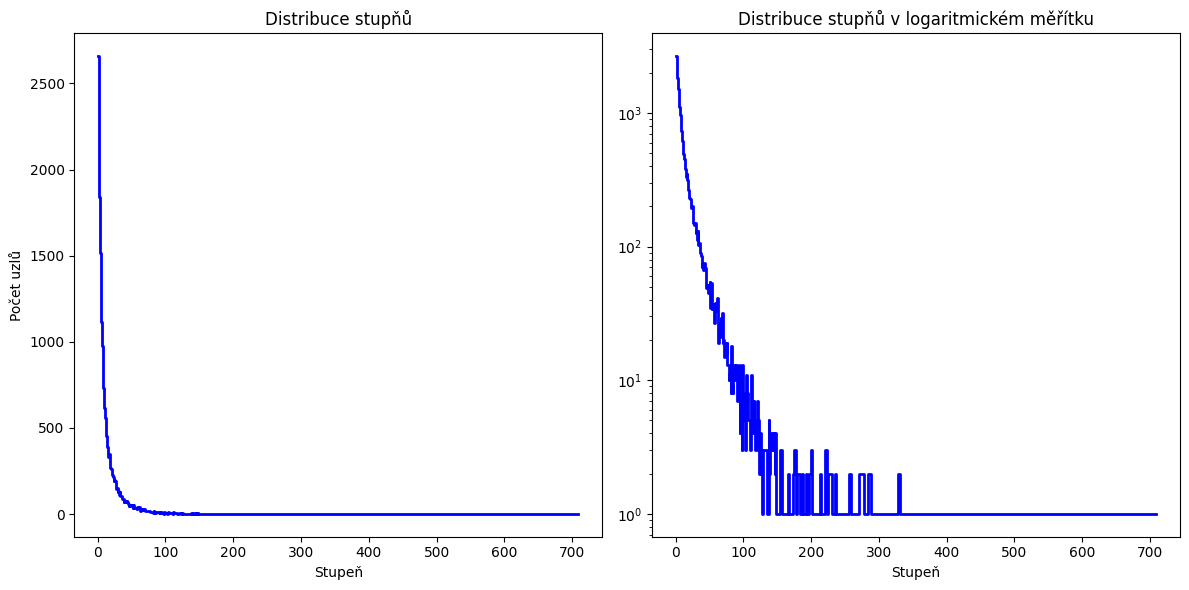

In [65]:
degree_values = gephi_df['Degree'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

# Linear scale plot
plt.subplot(1, 2, 1)
plt.step(degree_values.index, degree_values.values, where='mid', color='b', linewidth=2)
plt.title('Distribuce stupňů')
plt.xlabel('Stupeň')
plt.ylabel('Počet uzlů')

# Log scale plot
plt.subplot(1, 2, 2)
plt.step(degree_values.index, degree_values.values, where='mid', color='b', linewidth=2)
plt.yscale('log')
plt.title('Distribuce stupňů v logaritmickém měřítku')
plt.xlabel('Stupeň')

plt.tight_layout()
plt.savefig(save_path + 'degree_distribution.png')
plt.show()

### Distribuce stupňů v komunitách

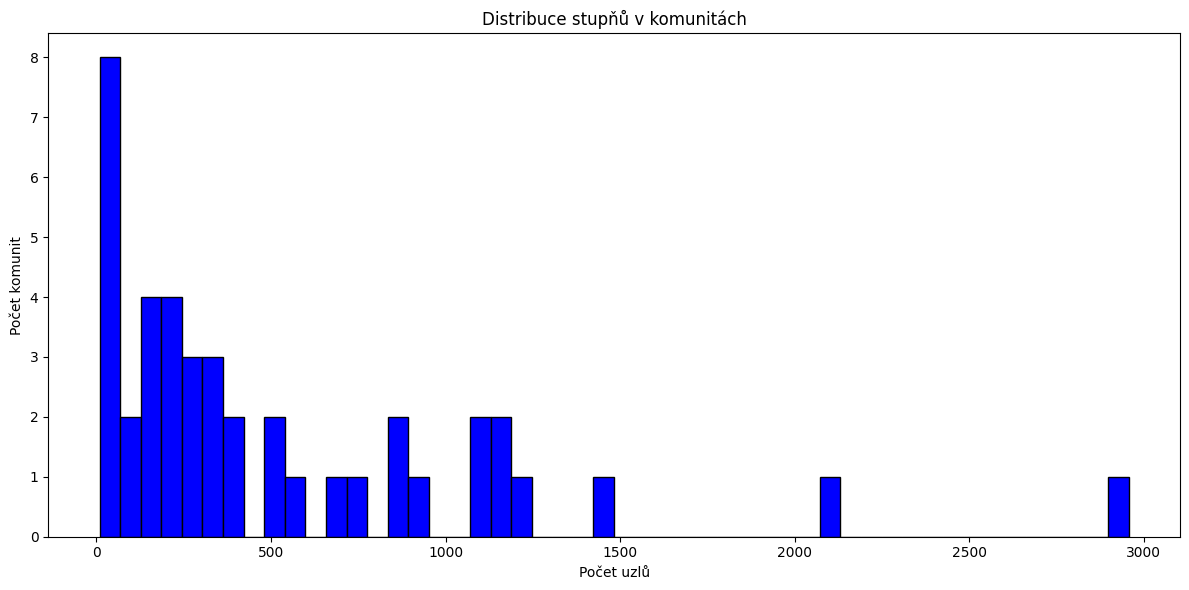

In [66]:
plt.figure(figsize=(12, 6))

plt.hist(community_sizes, bins=50, edgecolor='black', color='b')
plt.title('Distribuce stupňů v komunitách')
plt.xlabel('Počet uzlů')
plt.ylabel('Počet komunit')

plt.tight_layout()
plt.savefig(save_path + 'degree_distribution_communities.png')
plt.show()

## Shlukovací koeficient

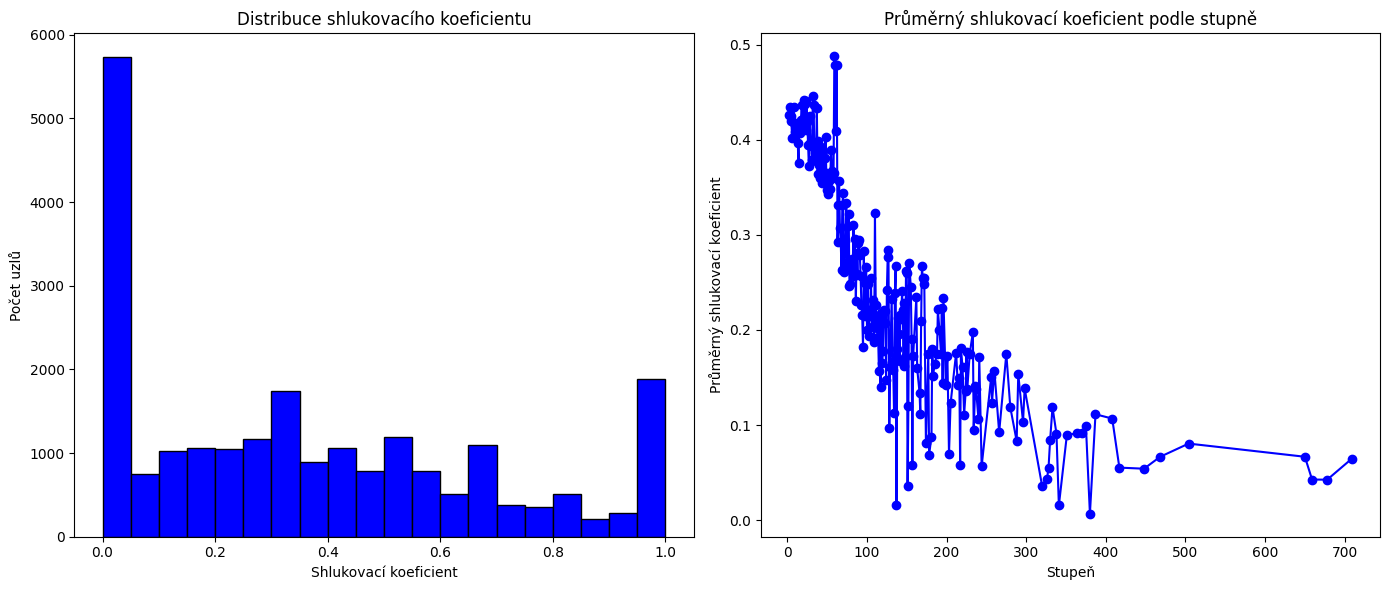

In [67]:
# Create 1x2 grid of subplots (side by side)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Degree Distribution
degree_values = list(dict(G.degree()).values())
degree_values_series = pd.Series(degree_values)
degree_values_counts = degree_values_series.value_counts().sort_index()
clustering_coeffs = nx.clustering(G)
degrees = list(dict(G.degree()).values())

ax[0].hist(list(clustering_coeffs.values()), bins=20, edgecolor='black', color='b')
ax[0].set_title('Distribuce shlukovacího koeficientu')
ax[0].set_xlabel('Shlukovací koeficient')
ax[0].set_ylabel('Počet uzlů')

# Calculate Average Clustering Coefficient by Degree
avg_cc_by_degree = {}
for degree in set(degrees):
    nodes_with_degree = [n for n, d in G.degree() if d == degree]
    avg_cc_by_degree[degree] = sum(clustering_coeffs[n] for n in nodes_with_degree) / len(nodes_with_degree)

# Plot Average Clustering Coefficient by Degree
degree_vals, cc_vals = zip(*sorted(avg_cc_by_degree.items()))
# skip zero degrees since we have no data for them, and it would mess up the plot
degree_vals = degree_vals[1:]
cc_vals = cc_vals[1:]
ax[1].plot(degree_vals, cc_vals, 'bo-')
ax[1].set_title('Průměrný shlukovací koeficient podle stupně')
ax[1].set_xlabel('Stupeň')
ax[1].set_ylabel('Průměrný shlukovací koeficient')

plt.tight_layout()
plt.savefig(save_path + 'clustering_coefficient.png')
plt.show()

### Distribuce stupňů v jednotlivých kategoriích

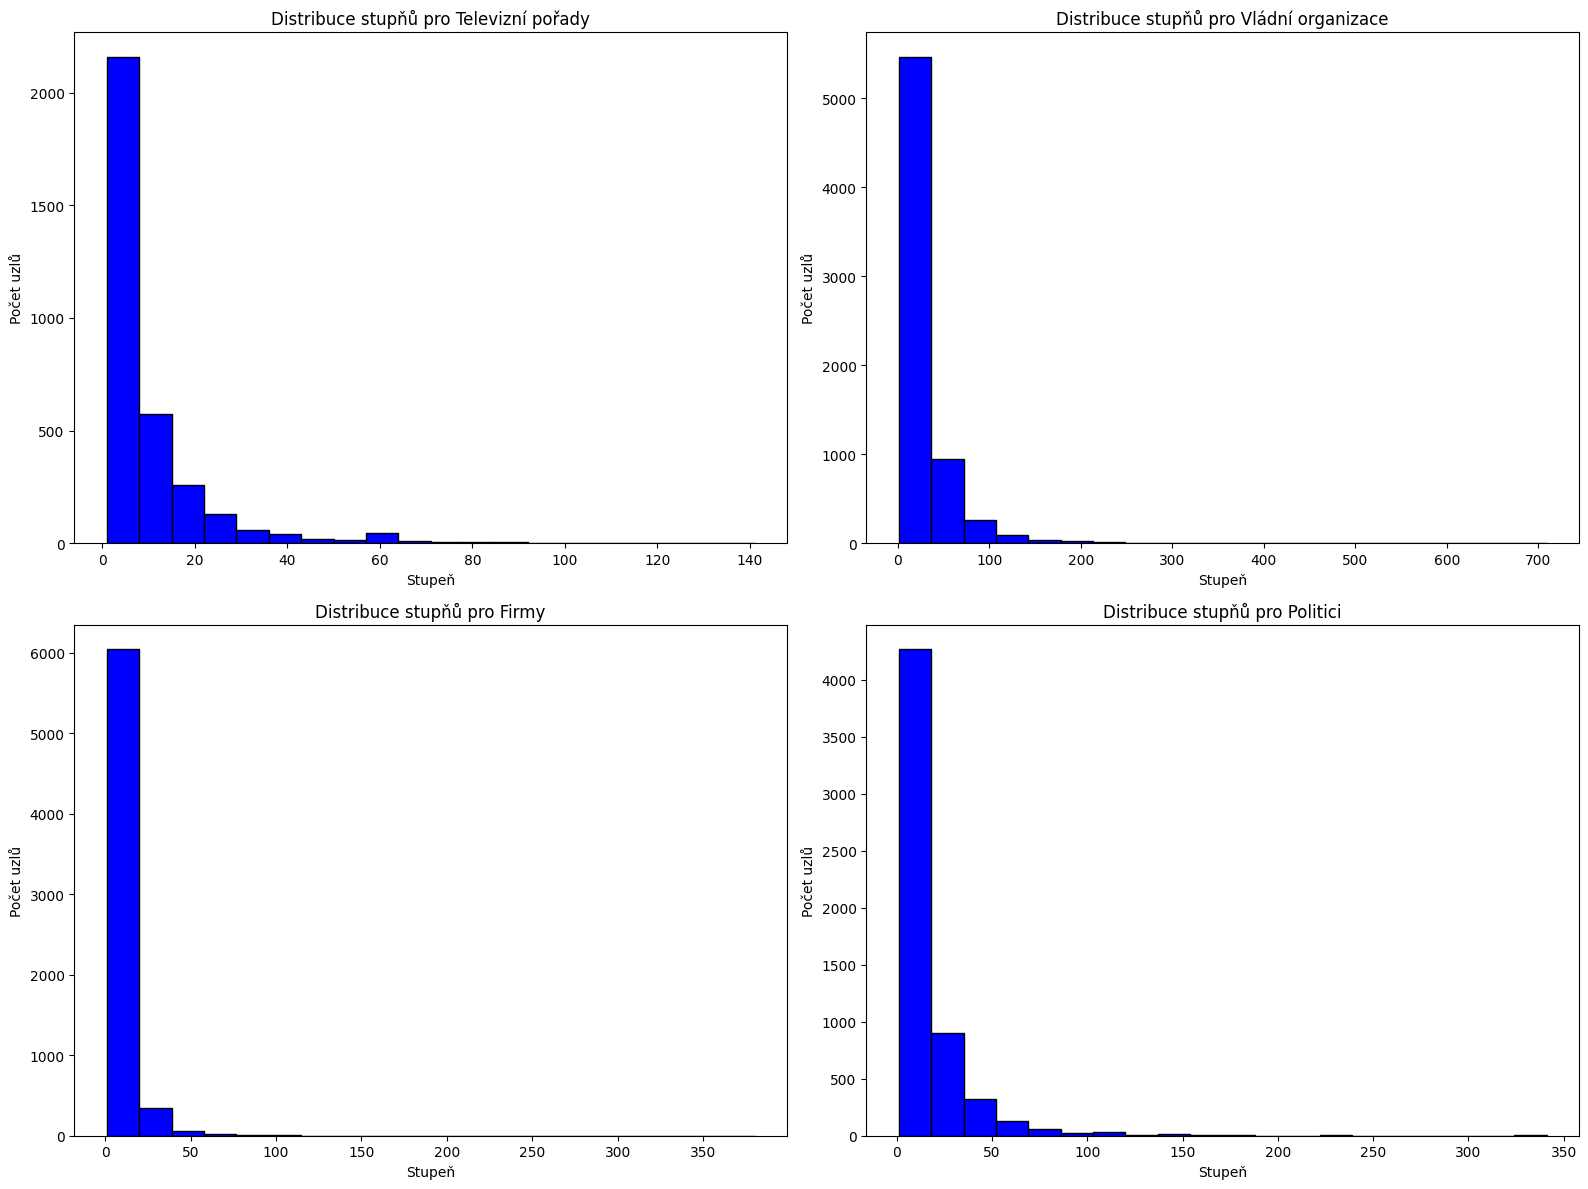

In [68]:
# Create 2x2 grid of subplots of degree distributions in each page_type
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Drop rows with NaN values in 'page_type' and 'Degree' columns
gephi_df_clean = gephi_df.dropna(subset=['page_type', 'Degree'])

page_type_dict_mapping = {
    'tvshow': 'Televizní pořady',
    'politician': 'Politici',
    'government': 'Vládní organizace',
    'company': 'Firmy'
}

# Plot Degree Distribution for each page_type
for i, page_type in enumerate(gephi_df_clean['page_type'].unique()):
    page_type_df = gephi_df_clean[gephi_df_clean['page_type'] == page_type]
    degree_values = list(page_type_df['Degree'])

    ax[i // 2, i % 2].hist(degree_values, bins=20, edgecolor='black', color='b')
    ax[i // 2, i % 2].set_title(f'Distribuce stupňů pro {page_type_dict_mapping[page_type]}')
    ax[i // 2, i % 2].set_xlabel('Stupeň')
    ax[i // 2, i % 2].set_ylabel('Počet uzlů')

plt.tight_layout()
plt.savefig(save_path + 'degree_distribution_by_category.png')
plt.show()

## Degree centrality & Betweenness centrality

In [ ]:
# Create 1x2 grid of subplots (side by side)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Degree Centrality
nodes = list(G.nodes())
degree_values = list(nx.degree_centrality(G).values())

# Approximate Betweenness Centrality
between_values = list(nx.betweenness_centrality(G, k=100, seed=42).values())

# Plot Degree Centrality
ax[0].bar(nodes, degree_values, color='b')
ax[0].set_title('Stupňová centralita')
ax[0].set_xlabel('Uzly')
ax[0].set_ylabel('Stupňová centralita')

# Plot Betweenness Centrality
ax[1].bar(nodes, between_values, color='b')
ax[1].set_title('Betweenness centralita')
ax[1].set_xlabel('Uzly')
ax[1].set_ylabel('Betweenness centralita')

plt.tight_layout()
plt.savefig(save_path + 'centrality.png')
plt.show()